In [1]:
from pandas import read_csv, set_option, get_dummies, DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
from numpy import mean, max, prod, array, hstack
from numpy.random import choice
from matplotlib.pyplot import barh, yticks, ylabel, xlabel, title, show, scatter, cm, figure, imshow
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tqdm import tqdm


set_option('display.max_columns', None)
set_option('display.max_rows', None)

In [2]:
def build_autoencoder(dim_input, dim_layer_1, dim_layer_2):
    
    input_layer = Input(shape=(dim_input,))
    x = Activation("relu")(input_layer)
    x = Dense(dim_layer_1)(x)
    x = Activation("relu")(x)
    bottleneck_layer = Dense(dim_layer_2)(x)
    x = Activation("relu")(bottleneck_layer)
    x = Dense(dim_layer_1)(x)
    x = Activation("relu")(x)    
    output_layer = Dense(dim_input, activation='relu')(x)
    
    encoder = Model(input_layer, bottleneck_layer)
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), prod(X_test.shape[1:])))

In [5]:
autoencoder, encoder = build_autoencoder(
    dim_input=X_train.shape[1], 
    dim_layer_1=64,
    dim_layer_2=16
)

In [6]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
activation (Activation)      (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1088

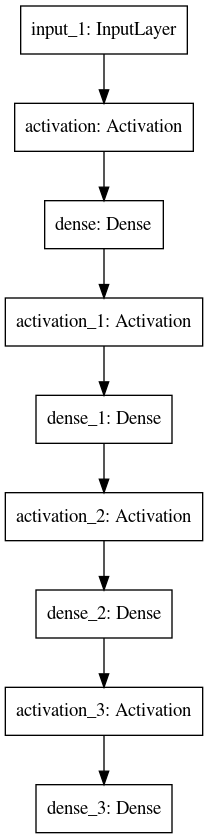

In [7]:
plot_model(autoencoder)

In [8]:
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        min_delta=0.0001,
        patience=5, 
        restore_best_weights=True
    )
]

In [9]:
autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_split=0.3,
    callbacks=callbacks
)

Epoch 1/100
165/165 [==============================] - 1s 4ms/step - loss: 0.0520 - val_loss: 0.0351
Epoch 2/100
165/165 [==============================] - 1s 4ms/step - loss: 0.0326 - val_loss: 0.0311
Epoch 3/100
165/165 [==============================] - 1s 5ms/step - loss: 0.0298 - val_loss: 0.0294
Epoch 4/100
165/165 [==============================] - 1s 4ms/step - loss: 0.0283 - val_loss: 0.0281
Epoch 5/100
165/165 [==============================] - 1s 4ms/step - loss: 0.0275 - val_loss: 0.0278
Epoch 6/100
165/165 [==============================] - 1s 4ms/step - loss: 0.0270 - val_loss: 0.0270
Epoch 7/100
165/165 [==============================] - 1s 4ms/step - loss: 0.0265 - val_loss: 0.0266
Epoch 8/100
165/165 [==============================] - 1s 5ms/step - loss: 0.0257 - val_loss: 0.0255
Epoch 9/100
165/165 [==============================] - 1s 5ms/step - loss: 0.0249 - val_loss: 0.0250
Epoch 10/100
165/165 [==============================] - 1s 6ms/step - loss: 0.0245 - val_lo

In [10]:
encoded = array(encoder(X_test))
decoded = array(autoencoder(X_test))

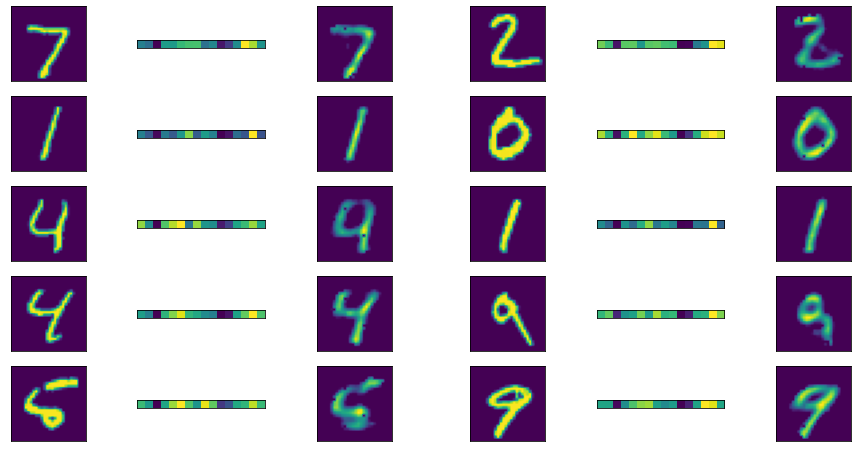

In [11]:
fig = figure(figsize=(16, 8))

n_plots = 10
n_rows = int(n_plots/2)

for j in range(n_plots):
    
    fig.add_subplot(n_rows, 6, 3*j+1)
    plot_tmp = imshow(X_test[j].reshape([28, 28]))
    plot_tmp.axes.get_xaxis().set_visible(False)
    plot_tmp.axes.get_yaxis().set_visible(False)
    
    fig.add_subplot(n_rows, 6, 3*j+2)
    plot_tmp = imshow(encoded[j].reshape([1, 16]))
    plot_tmp.axes.get_xaxis().set_visible(False)
    plot_tmp.axes.get_yaxis().set_visible(False)
    
    fig.add_subplot(n_rows, 6, 3*j+3)
    plot_tmp = imshow(decoded[j].reshape([28, 28]))
    plot_tmp.axes.get_xaxis().set_visible(False)
    plot_tmp.axes.get_yaxis().set_visible(False)
    
show()

In [12]:
df = read_csv("data/bank-additional-full.csv", sep=";")
y = (df.y == "yes") + 0
del df["duration"]
del df["y"]

In [13]:
sum(y) / len(y)

0.11265417111780131

In [14]:
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
16533,31,services,divorced,high.school,no,no,no,telephone,jul,wed,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
25956,39,blue-collar,married,basic.9y,unknown,no,yes,cellular,nov,wed,1,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8
9430,29,technician,married,university.degree,no,no,yes,telephone,jun,fri,4,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1
25339,45,entrepreneur,married,basic.4y,no,yes,no,cellular,nov,tue,5,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8
39163,36,management,single,university.degree,no,no,no,telephone,mar,wed,1,999,0,nonexistent,-1.8,93.369,-34.8,0.655,5008.7


In [15]:
X = get_dummies(df)
array_columns = X.columns
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [16]:
DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.284248,0.028502,0.963439,0.024709,0.725393,0.535723,0.430854,0.677237,0.769134,0.253035,0.224677,0.035350,0.025736,0.070992,0.041760,0.034500,0.096363,0.021244,0.163713,0.024619,0.008012,0.111974,0.605225,0.280859,0.001942,0.101389,0.055647,0.146766,0.231014,0.000437,0.127294,0.295426,0.042027,0.791201,0.208726,0.000073,0.452122,0.024036,0.523842,0.824269,0.024036,0.151695,0.634748,0.365252,0.063902,0.149995,0.004419,0.174177,0.129115,0.013256,0.334296,0.099568,0.017432,0.013839,0.190031,0.206711,0.209357,0.196416,0.197485,0.103234,0.863431,0.033335
std,0.128657,0.050364,0.187098,0.070700,0.327283,0.225581,0.193648,0.393210,0.273163,0.434756,0.417375,0.184665,0.158348,0.256814,0.200042,0.182513,0.295092,0.144199,0.370019,0.154962,0.089152,0.315339,0.488808,0.449424,0.044029,0.301846,0.229242,0.353877,0.421486,0.020901,0.333306,0.456239,0.200653,0.406455,0.406403,0.008534,0.497708,0.153163,0.499437,0.380596,0.153163,0.358729,0.481507,0.481507,0.244581,0.357071,0.066328,0.379266,0.335332,0.114372,0.471750,0.299427,0.130877,0.116824,0.392330,0.404951,0.406855,0.397292,0.398106,0.304268,0.343396,0.179512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.185185,0.000000,1.000000,0.000000,0.333333,0.340608,0.338912,0.160961,0.512287,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.259259,0.018182,1.000000,0.000000,0.937500,0.603274,0.376569,0.957379,0.859735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.370370,0.036364,1.000000,0.000000,1.000000,0.698753,0.602510,0.980957,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [17]:
rf = RandomForestClassifier(
    n_estimators=500, 
    max_depth=2, 
    n_jobs=8, 
    random_state=42
)

In [18]:
dict_performance = cross_validate(
    estimator=rf, 
    X=X, y=y, 
    cv=10, 
    n_jobs=4,
    return_train_score=True,
    scoring=[
        "balanced_accuracy", 
        "f1_weighted", 
        "roc_auc", 
        "average_precision"
    ]
)

df_performance = DataFrame(
    {"ORIGINAL": [mean(dict_performance[k]) \
                  for k in dict_performance.keys()]}, 
    index=dict_performance.keys()
)

In [19]:
df_performance

,ORIGINAL
fit_time,8.061133
score_time,0.830988
test_balanced_accuracy,0.505833
train_balanced_accuracy,0.517641
test_f1_weighted,0.809805
train_f1_weighted,0.842227
test_roc_auc,0.563038
train_roc_auc,0.801313
test_average_precision,0.414990
train_average_precision,0.463692


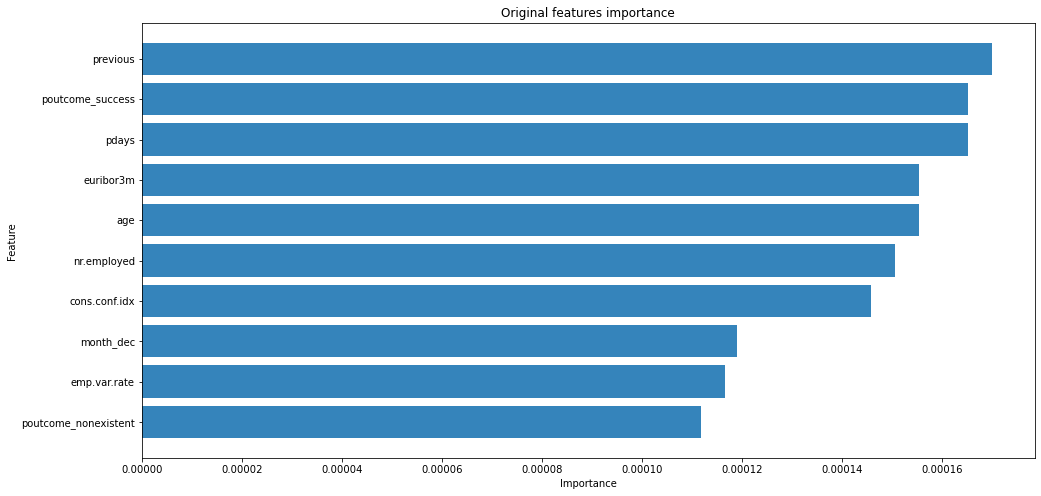

In [20]:
rf = RandomForestClassifier(
    n_estimators=500, 
    max_depth=2, 
    n_jobs=8, 
    random_state=42
)
rf.fit(X, y)
fi = permutation_importance(
    estimator=rf, 
    X=X, 
    y=y, 
    n_repeats=10, 
    n_jobs=8, 
    random_state=42
).importances_mean

figure(figsize=(16,8))
barh(
    y=range(10, 0, -1), 
    width=sorted(fi, reverse=True)[:10], 
    alpha=0.9
)
ylabel("Feature")
yticks(
    range(10, 0, -1), 
    array_columns[fi.argsort()[::-1][:10]]
)
xlabel("Importance")
title("Original features importance")
show()

In [21]:
dim_layer_input = X.shape[1]
dim_layer_1 = max((int(3*dim_layer_input/4), 1))
dim_layer_2 = max((int(dim_layer_input/2), 1))
autoencoder, encoder = build_autoencoder(
    dim_input=dim_layer_input, 
    dim_layer_1=dim_layer_1, 
    dim_layer_2=dim_layer_2
)

In [22]:
autoencoder.fit(
    X, X,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_split=0.3,
    callbacks=callbacks
)

Epoch 1/100
113/113 [==============================] - 1s 4ms/step - loss: 0.1154 - val_loss: 0.0908
Epoch 2/100
113/113 [==============================] - 0s 4ms/step - loss: 0.0401 - val_loss: 0.0658
Epoch 3/100
113/113 [==============================] - 0s 4ms/step - loss: 0.0260 - val_loss: 0.0584
Epoch 4/100
113/113 [==============================] - 0s 3ms/step - loss: 0.0220 - val_loss: 0.0564
Epoch 5/100
113/113 [==============================] - 0s 3ms/step - loss: 0.0207 - val_loss: 0.0538
Epoch 6/100
113/113 [==============================] - 0s 3ms/step - loss: 0.0198 - val_loss: 0.0505
Epoch 7/100
113/113 [==============================] - 0s 3ms/step - loss: 0.0193 - val_loss: 0.0497
Epoch 8/100
113/113 [==============================] - 0s 4ms/step - loss: 0.0191 - val_loss: 0.0496
Epoch 9/100
113/113 [==============================] - 0s 4ms/step - loss: 0.0190 - val_loss: 0.0492
Epoch 10/100
113/113 [==============================] - 0s 4ms/step - loss: 0.0190 - val_lo

In [23]:
encoded = array(encoder(X))

In [24]:
rf = RandomForestClassifier(
    n_estimators=500, 
    max_depth=2, 
    n_jobs=8, 
    random_state=42
)
dict_performance = cross_validate(
    estimator=rf, 
    X=encoded, y=y, 
    cv=10, 
    n_jobs=4,
    return_train_score=True,
    scoring=[
        "balanced_accuracy", 
        "f1_weighted", 
        "roc_auc", 
        "average_precision"
    ]
)

df_performance["ENCODED"] = [
    mean(dict_performance[k]) \
    for k in dict_performance.keys()
]

In [25]:
df_performance

,ORIGINAL,ENCODED
fit_time,8.061133,26.388137
score_time,0.830988,1.053183
test_balanced_accuracy,0.505833,0.503019
train_balanced_accuracy,0.517641,0.501363
test_f1_weighted,0.809805,0.835511
train_f1_weighted,0.842227,0.835109
test_roc_auc,0.563038,0.722752
train_roc_auc,0.801313,0.762064
test_average_precision,0.414990,0.525588
train_average_precision,0.463692,0.383266


In [26]:
array_columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_s

In [27]:
feat_pers = ['age', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown','job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown']
feat_fina = ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes']
feat_camp = ['campaign', 'pdays', 'previous', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success']
feat_econ = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

print(len(feat_pers), len(feat_fina), len(feat_camp), len(feat_econ), len(feat_pers) + len(feat_fina) + len(feat_camp) + len(feat_econ) == len(array_columns))

25 9 23 5 True


In [28]:
feat_groups = [
    feat_pers, 
    feat_fina, 
    feat_camp, 
    feat_econ
]
encoded = []

for g in tqdm(feat_groups):
    
    dim_layer_input = len(g)
    dim_layer_1 = max((int(3*dim_layer_input/4), 1))
    dim_layer_2 = max((int(dim_layer_input / 2), 1))
    
    autoencoder, encoder = build_autoencoder(
        dim_input=dim_layer_input, 
        dim_layer_1=dim_layer_1, 
        dim_layer_2=dim_layer_2
    )
    
    X_tmp = X[:, array_columns.isin(g)]
    autoencoder.fit(
        X_tmp, X_tmp,
        epochs=100,
        batch_size=256,
        shuffle=True,
        validation_split=0.3,
        callbacks=callbacks, 
        verbose=0
    )
    
    encoded.append(array(encoder(X_tmp)))

100%|██████████| 4/4 [00:34<00:00,  8.51s/it]


In [29]:
X_encoded = hstack(encoded)

In [30]:
array_encoded_features = array(
    ["pers_"+str(j) for j in range(encoded[0].shape[1])] + \
    ["fina_"+str(j) for j in range(encoded[1].shape[1])] + \
    ["camp_"+str(j) for j in range(encoded[2].shape[1])] + \
    ["econ_"+str(j) for j in range(encoded[3].shape[1])]
)

In [31]:
DataFrame(X_encoded, columns=array_encoded_features).sample(5)

,pers_0,pers_1,pers_2,pers_3,pers_4,pers_5,pers_6,pers_7,pers_8,pers_9,pers_10,pers_11,fina_0,fina_1,fina_2,fina_3,camp_0,camp_1,camp_2,camp_3,camp_4,camp_5,camp_6,camp_7,camp_8,camp_9,camp_10,econ_0,econ_1
14271,1.766457,-1.858506,1.527646,0.967267,1.197702,1.685395,1.742300,1.521291,3.352483,3.295268,2.039039,0.819601,-1.159335,3.072608,2.940951,1.715309,0.756437,1.554016,0.125771,0.818307,-0.655496,-0.257394,2.263055,1.110901,1.666754,2.315678,0.594455,-0.073504,0.706128
38110,1.900608,-1.289555,0.934587,1.264449,0.917077,2.590348,1.985073,0.344954,3.171203,1.493695,1.479075,1.615082,-0.655238,3.922607,1.190354,3.957587,0.836479,1.537111,0.096256,0.534085,-0.718423,0.121315,1.322045,-0.155505,0.959476,1.752178,-0.003634,-0.032568,0.069207
9613,0.727200,-1.494521,0.445399,2.098301,1.099392,1.233449,2.386735,0.855103,2.531948,2.135375,1.562708,0.578137,1.579593,6.062159,-1.143997,0.049949,1.806336,0.627548,1.027021,1.162885,-0.387225,-0.350623,2.001506,1.404485,1.161019,2.686127,0.844868,-0.015803,0.810468
19167,3.136367,-1.855610,0.047800,3.380212,0.777369,1.076406,1.276556,1.325401,1.310340,2.068194,3.934725,0.668451,-0.655238,3.922607,1.190354,3.957587,0.930507,1.777684,-0.117286,0.521362,-0.757560,-0.009650,1.765950,-0.012735,0.811082,1.673729,0.311292,-0.076619,0.657558
11861,3.687668,-1.844795,0.373193,2.627980,0.973278,1.552355,1.002753,0.830468,1.814662,2.220145,4.481116,0.567920,-0.865288,2.007591,1.253906,2.867021,2.064615,1.125823,0.756587,1.146341,-0.359168,-0.276827,1.921229,0.782431,0.134812,1.864548,1.563612,-0.015927,0.810330


In [32]:
X_encoded.shape

(41188, 29)

In [33]:
X.shape

(41188, 62)

In [34]:
rf = RandomForestClassifier(n_estimators=500, max_depth=2, n_jobs=8, random_state=42)

dict_performance = cross_validate(
    estimator=rf, 
    X=X_encoded, y=y, 
    cv=10, 
    n_jobs=4,
    return_train_score=True,
    scoring=[
        "balanced_accuracy", 
        "f1_weighted", 
        "roc_auc", 
        "average_precision"
    ]
)

df_performance["GROUP_ENCODED"] = [mean(dict_performance[k]) for k in dict_performance.keys()]

In [35]:
df_performance

,ORIGINAL,ENCODED,GROUP_ENCODED
fit_time,8.061133,26.388137,14.218396
score_time,0.830988,1.053183,0.853897
test_balanced_accuracy,0.505833,0.503019,0.523597
train_balanced_accuracy,0.517641,0.501363,0.528023
test_f1_weighted,0.809805,0.835511,0.838770
train_f1_weighted,0.842227,0.835109,0.848629
test_roc_auc,0.563038,0.722752,0.493781
train_roc_auc,0.801313,0.762064,0.791968
test_average_precision,0.414990,0.525588,0.303416
train_average_precision,0.463692,0.383266,0.454403


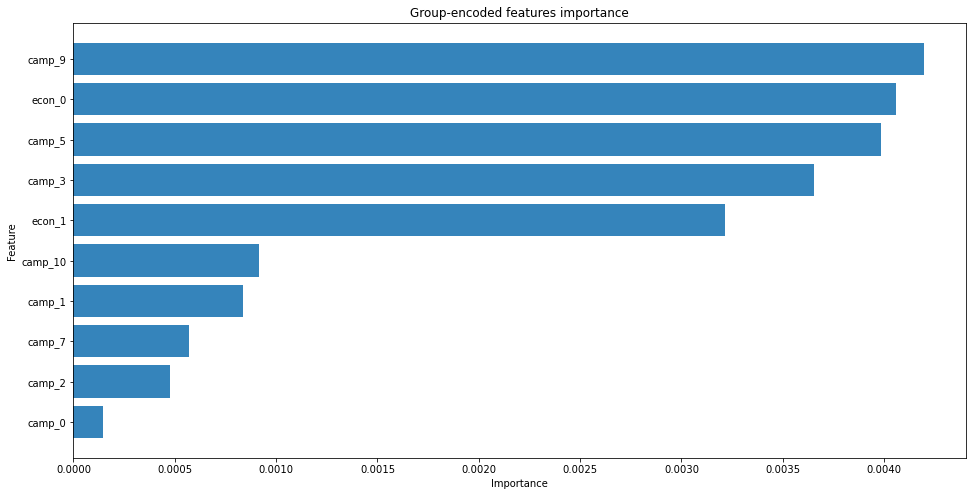

In [36]:
rf = RandomForestClassifier(
    n_estimators=500, 
    max_depth=2, 
    n_jobs=8, 
    random_state=42
)
rf.fit(X_encoded, y)
fi = permutation_importance(
    estimator=rf, 
    X=X_encoded, 
    y=y, 
    n_repeats=10, 
    n_jobs=8, 
    random_state=42
).importances_mean

figure(figsize=(16,8))
barh(
    y=range(10, 0, -1), 
    width=sorted(fi, reverse=True)[:10], 
    alpha=0.9
)
ylabel("Feature")
yticks(
    range(10, 0, -1), 
    array_encoded_features[fi.argsort()[::-1][:10]]
)
xlabel("Importance")
title("Group-encoded features importance")
show()